In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras import datasets ,layers,models
import matplotlib.pyplot as plt
from keras.applications import VGG19
from keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications import *
from keras.callbacks import ReduceLROnPlateau

import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

In [2]:
IMG_SIZE = 256
BATCH_SIZE = 32
NB_CHANNELS = 3
NB_CLASSES = 15

## Creating the Dataset using keras.preprocessing.image_dataset_from_directory

In [3]:

### train = ImageDataGenerator(rescale = 1/255)
train = ImageDataGenerator(rescale=1./255,
        validation_split=0.2,
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images



In [4]:
train_dataset = train.flow_from_directory(
        '../input/plant-village/PlantVillage',
        target_size=(256, 256), 
        subset="training",
        shuffle=True,
        class_mode='sparse')
val_dataset = train.flow_from_directory(
        '../input/plant-village/PlantVillage',
        target_size=(256, 256), 
        subset="validation",
        shuffle=True,
        class_mode='sparse')

Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.


In [5]:
val_dataset.class_indices


{'Pepper__bell___Bacterial_spot': 0,
 'Pepper__bell___healthy': 1,
 'Potato___Early_blight': 2,
 'Potato___Late_blight': 3,
 'Potato___healthy': 4,
 'Tomato_Bacterial_spot': 5,
 'Tomato_Early_blight': 6,
 'Tomato_Late_blight': 7,
 'Tomato_Leaf_Mold': 8,
 'Tomato_Septoria_leaf_spot': 9,
 'Tomato_Spider_mites_Two_spotted_spider_mite': 10,
 'Tomato__Target_Spot': 11,
 'Tomato__Tomato_YellowLeaf__Curl_Virus': 12,
 'Tomato__Tomato_mosaic_virus': 13,
 'Tomato_healthy': 14}

# Creating the Dataset using tf.keras.preprocessing.image_dataset_from_directory

In [6]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../input/plant-village/PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 20638 files belonging to 15 classes.


In [7]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [8]:

for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[14  9 14  6  3  0  7  6  3 11  9  8  5  3  3  5  5  9 10  6 14 14  2  2
 14  6  5  2  9 12  2  8]


(32, 256, 256, 3)
[ 7  2  5 12  7 14  8  6  7  5  5 10  8  5  5 14  5  1 12 12  9  8  6  9
 12  7 12  2 14  7  6  0]


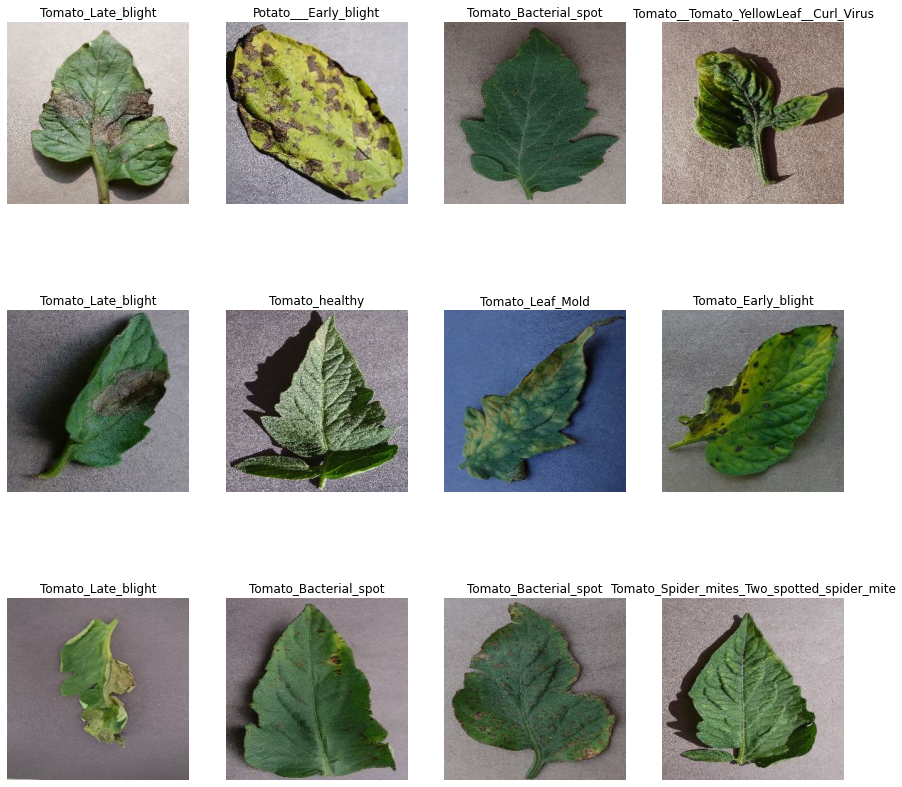

In [9]:
plt.figure(figsize=(15,15))
for image_batch , label_batch in dataset.take(1) :
    #convert the array from tensor to numpy array
    print(image_batch.shape)
    print(label_batch.numpy())
    for i in range(12) : 
        ax = plt.subplot(3,4,i+1)
        #convert the array from tensor to numpy array
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [10]:
def get_dataset_partition(ds , train_split=0.8, val_split=0.1, test_split=0.1, shuffle = True, shuffle_size=10000 ) : 
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(val_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [11]:
train_ds , val_ds , test_ds = get_dataset_partition(dataset)

In [12]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.TakeDataset

In [13]:
len(train_ds)

516

# in this part , will use the tf.data API to build highly performant TensorFlow input pipelines for those who are going to implement this code locally 

Under the hood, this is how  execution time was spent on a specific Dataset 
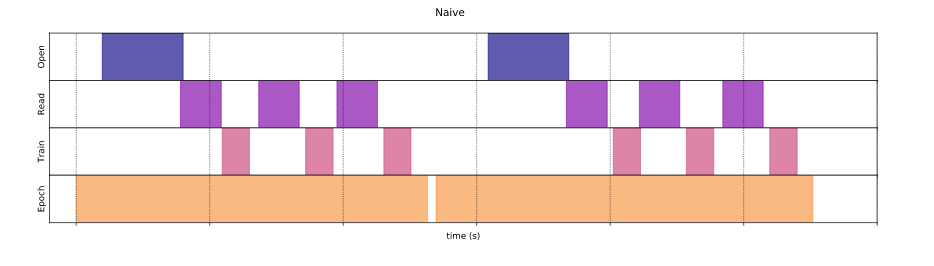

# Prefetching
The tf.data API provides the tf.data.Dataset.prefetch transformation. It can be used to decouple the time when data is produced from the time when data is consumed
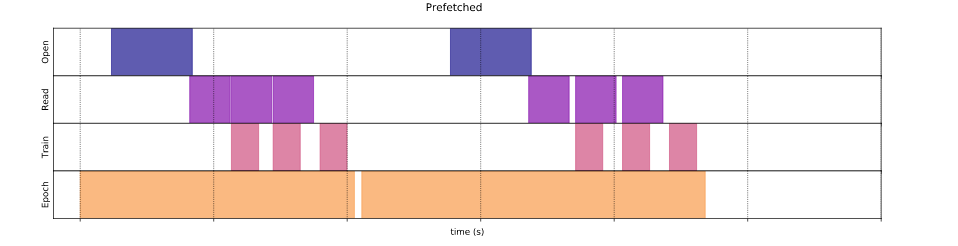

# Caching
The tf.data.Dataset.cache transformation can cache a dataset, either in memory or on local storage. This will save some operations (like file opening and data reading) from being executed during each epoch.
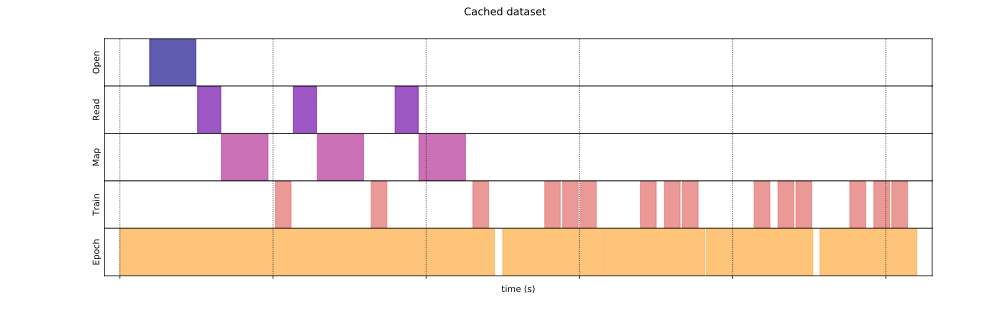

In [14]:

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)


In [15]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [16]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

# build a cnn model

In [17]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding="same",input_shape = (IMG_SIZE , IMG_SIZE , NB_CHANNELS)))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=1))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=1))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=1))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dense(NB_CLASSES))
model.add(Activation("softmax"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      1024      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 85, 85, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 85, 85, 64)       

##### 

In [18]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience = 2,
                                            verbose=1,
                                            factor=0.1,
                                            min_lr=0.000001)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
history = model.fit(train_dataset ,validation_data = val_dataset , batch_size = 32 , epochs = 18  , shuffle=True,callbacks = [learning_rate_reduction])
history
model.save('./plant_model')

Epoch 1/18
517/517 [==============================] - 402s 764ms/step - loss: 1.6672 - accuracy: 0.5114 - val_loss: 2.2192 - val_accuracy: 0.4862
Epoch 2/18
517/517 [==============================] - 317s 613ms/step - loss: 0.8416 - accuracy: 0.7290 - val_loss: 0.8824 - val_accuracy: 0.7407
Epoch 3/18
517/517 [==============================] - 320s 619ms/step - loss: 0.7110 - accuracy: 0.7690 - val_loss: 4.3802 - val_accuracy: 0.4272
Epoch 4/18
517/517 [==============================] - 345s 667ms/step - loss: 0.7969 - accuracy: 0.7481 - val_loss: 1.8767 - val_accuracy: 0.5631

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/18
517/517 [==============================] - 326s 632ms/step - loss: 0.4872 - accuracy: 0.8391 - val_loss: 0.4327 - val_accuracy: 0.8649
Epoch 6/18
517/517 [==============================] - 316s 611ms/step - loss: 0.4189 - accuracy: 0.8672 - val_loss: 0.3751 - val_accuracy: 0.8852
Epoch 7/18
517/517 [======================

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      1024      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 85, 85, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 85, 85, 64)       

In [ ]:
import keras
MODEL = tf.keras.models.load_model('./saved_model')